# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score

from feature_engine.datetime import DatetimeFeatures
import joblib
import matplotlib.pyplot as plt

# 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="default")

# 3. Get the Data

In [4]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
def split_data(df):
    X = df.drop(columns="price")
    y = df.price
    return (X, y)

In [8]:
X_train, y_train = split_data(train_df)

In [9]:
X_train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info


In [10]:
y_train.head()

0    4995
1    8372
2    6117
3    7770
4    9187
Name: price, dtype: int64

In [11]:
X_val, y_val = split_data(val_df)

In [12]:
X_test, y_test = split_data(test_df)

In [13]:
X_train.shape, y_train.shape

((640, 9), (640,))

In [14]:
X_val.shape, y_val.shape

((160, 9), (160,))

In [15]:
X_test.shape, y_test.shape

((200, 9), (200,))

# 4. Data Preprocessing

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [17]:
num_cols = ["duration", "total_stops"]
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [18]:
dt_cols, num_cols, cat_cols

(['date_of_journey', 'dep_time', 'arrival_time'],
 ['duration', 'total_stops'],
 ['airline', 'source', 'destination', 'additional_info'])

In [19]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])

In [20]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [21]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

#  5. Model Selection

In [22]:
data = pd.concat([train_df, val_df], axis=0)
data.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


In [23]:
X_data, y_data = split_data(data)
X_data.shape, y_data.shape

((800, 9), (800,))

In [24]:
algos = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XGBoost": XGBRegressor(n_estimators=10)
}

In [25]:
def plot_curves(sizes, avg_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        avg_scores,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=avg_scores - std_scores,
        y2=avg_scores + std_scores,
        alpha=0.5
    )

In [26]:
def plot_learning_curves(name, algo, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algo)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    avg_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{avg_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    avg_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{avg_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)
    
    #training curve
    plot_curves(train_sizes, avg_train_scores, std_train_scores,
               f"Train ({train_score})",
               ax)

    #testing curve
    plot_curves(train_sizes, avg_test_scores, std_test_scores,
               f"Test ({test_score})",
               ax)

    ax.set(xlabel="Training Set Size", ylabel="R-Square", title=name)
    ax.legend(loc="lower right")

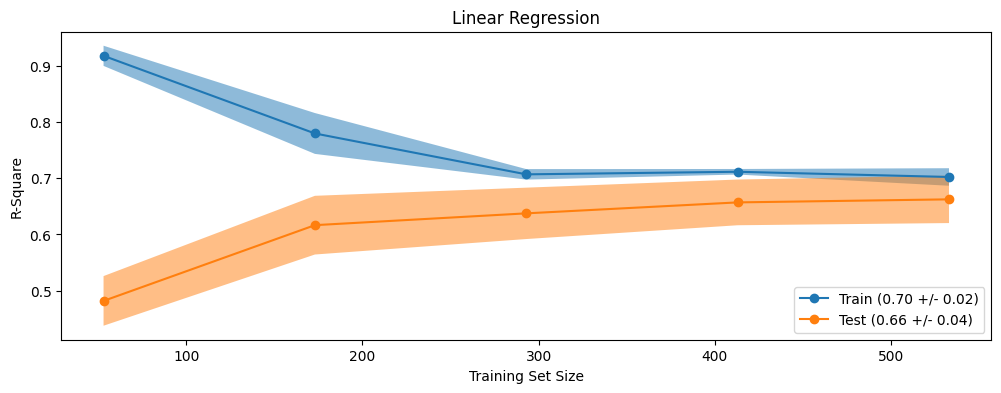

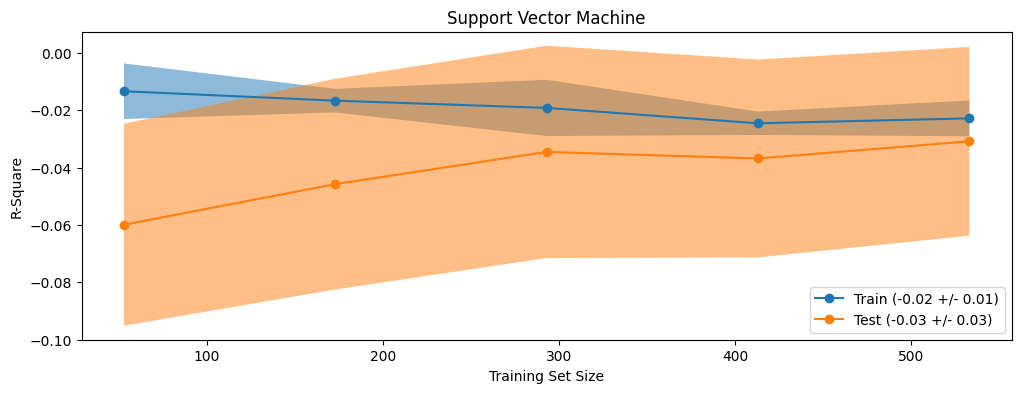

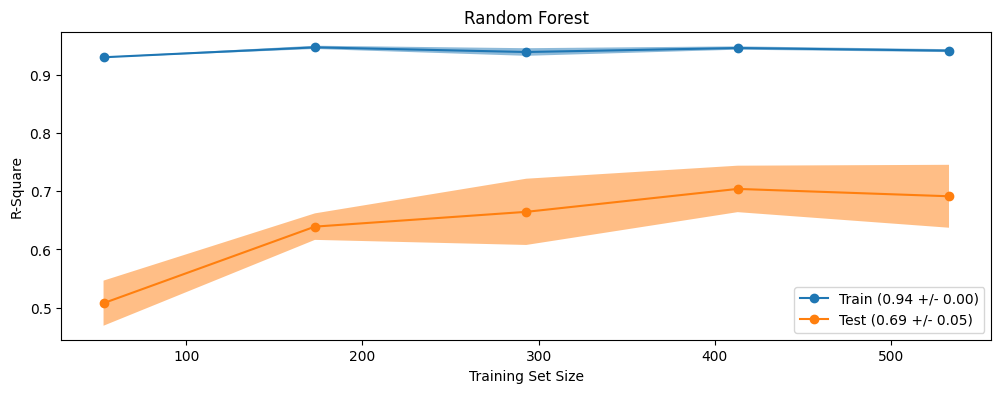

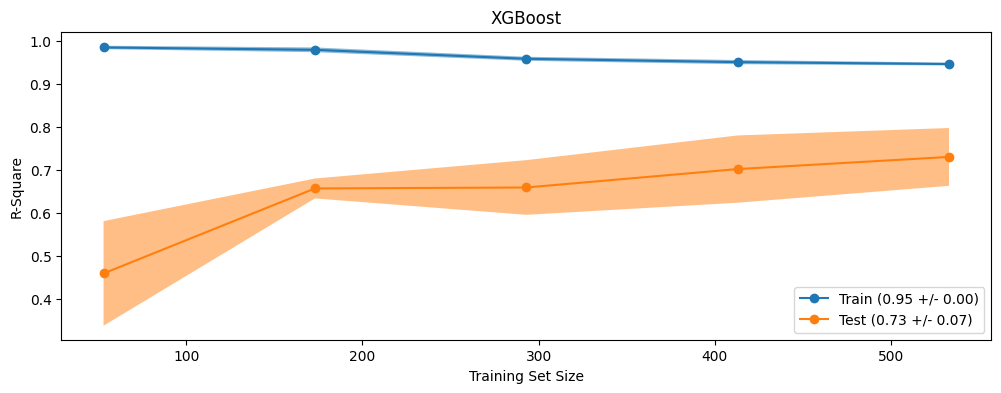

In [27]:
for name, algo in algos.items():
    plot_learning_curves(name, algo)

# 6. Model Training

In [28]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])

In [29]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'd...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

# 7. Evaluate

In [30]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [31]:
print(f"R2-Score = {evaluate_model(X_data, y_data)}")

R2-Score = 0.9054929984724676


In [32]:
print(f"R2-Score = {evaluate_model(X_test, y_test)}")

R2-Score = 0.7163108274296801


# 8. Saving

In [33]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [34]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'd...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [35]:
y_pred = saved_model.predict(X_test)
r2_score(y_test, y_pred)

0.7163108274296801